In [1]:
import sys
sys.path.append("../")
sys.path.append("../utils")
from utils import get_dataloader

train_dataloader, valid_dataloader, test_dataloader = get_dataloader(batch_size_set=512)

In [2]:
import torch.nn as nn
from torch.optim import Adam
from utils.model import residual_rnn

model = residual_rnn(h_dim=128)
model = model.to('cuda')

loss_fn = nn.MSELoss(reduction='sum')
optimizer = Adam(model.parameters(),lr=1e-3)

train_losses = []
valid_losses = []

bst_valid_loss = float("inf")

In [3]:
optimizer = Adam(model.parameters(),lr=1e-4)

In [4]:
import os
import torch
import pandas as pd
from utils.train_model import train_and_valid

epochs = 100

j = 0
while True:
    j = j+1
    path = f"./res/{j}"
    if not os.path.exists(path):
        os.makedirs(path)
        break

for i in range(epochs):
    train_loss = train_and_valid(model=model,
                                 dataloader=train_dataloader,
                                 loss_fn=loss_fn,
                                 mode='train',
                                 optimizer=optimizer)
    train_losses.append(train_loss)

    valid_loss = train_and_valid(model=model,
                                 dataloader=valid_dataloader,
                                 loss_fn=loss_fn,
                                 mode='valid')
    valid_losses.append(valid_loss)

    if valid_loss < bst_valid_loss:
        bst_valid_loss = valid_loss

        torch.save(model.state_dict(),f"{path}/tiny.pt")

    print(f'{i+1} STEP: TRAIN LOSS: {train_loss:.5f}, VALID LOSS: {valid_loss:.5f}')

df = pd.DataFrame({
    'Train Loss': train_losses,
    'Valid Loss': valid_losses
})
df.to_csv(f"{path}/res.csv",header=None)

1 STEP: TRAIN LOSS: 217.83841, VALID LOSS: 208.35696
2 STEP: TRAIN LOSS: 204.28031, VALID LOSS: 199.56226
3 STEP: TRAIN LOSS: 195.83934, VALID LOSS: 190.92075
4 STEP: TRAIN LOSS: 187.09401, VALID LOSS: 182.22151
5 STEP: TRAIN LOSS: 178.55096, VALID LOSS: 173.79958
6 STEP: TRAIN LOSS: 170.64269, VALID LOSS: 167.00564


KeyboardInterrupt: 

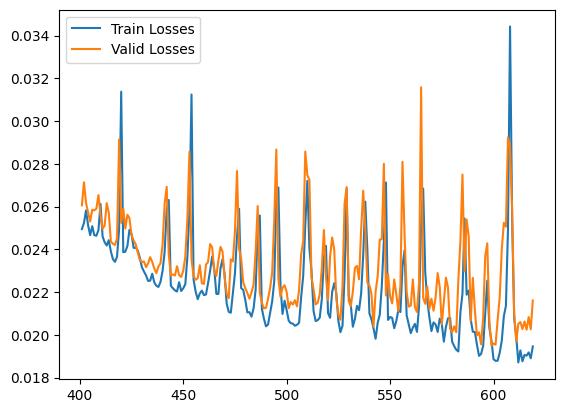

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_epochs = np.arange(len(train_losses))
train_epochs += 1
observe_point = 400

plt.plot(train_epochs[observe_point:],
         train_losses[observe_point:],
         label='Train Losses')
plt.plot(train_epochs[observe_point:],
         valid_losses[observe_point:],
         label='Valid Losses')
plt.legend()

训练集表现

In [ ]:
import torch
import numpy as np
from utils.train_model import train_and_valid, full_generate

test_model = residual_rnn(h_dim=128)
test_model = test_model.to('cuda')
model_index = 5
test_model.load_state_dict(torch.load(f"./res/{model_index}/tiny.pt"))

test_loss = train_and_valid(model=test_model,
                            dataloader=test_dataloader,
                            loss_fn=loss_fn,
                            mode='valid')
print(test_loss)

0.020560293035086625


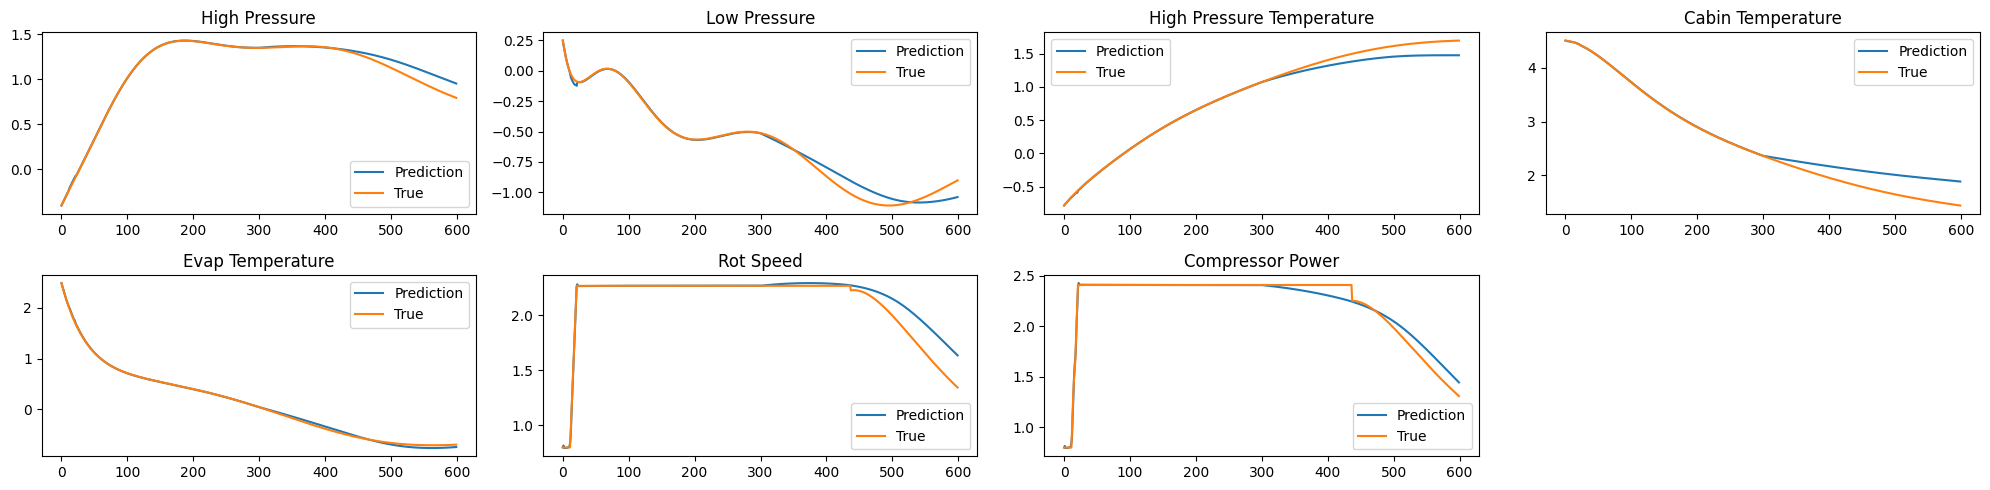

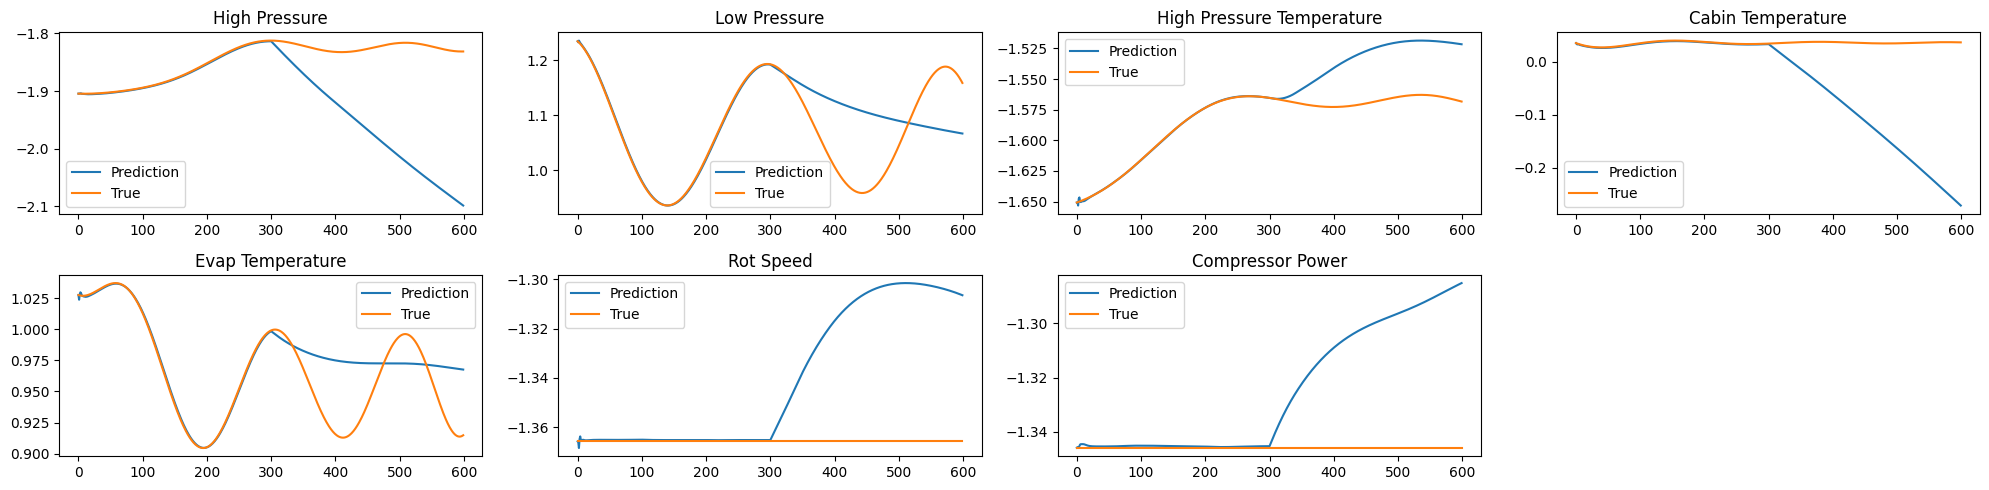

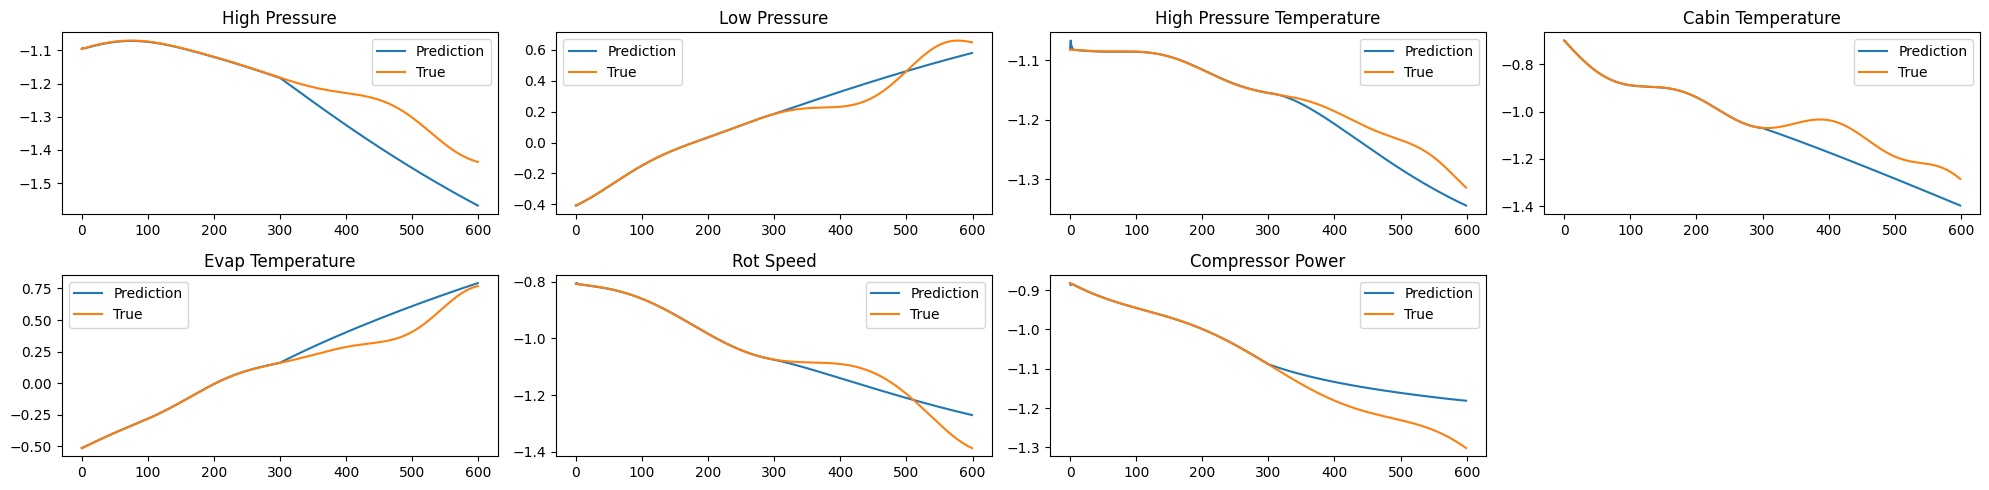

In [ ]:
import matplotlib.pyplot as plt

for input,label in test_dataloader:
    batch_size = input.shape[0]
    random_size = 3
    random_sample = np.random.choice(np.arange(batch_size),size=random_size,replace=False)

    random_input = input[random_sample,:,:]
    random_label = label[random_sample,:,:]

    random_input = random_input.to('cuda')
    label_len = random_label.shape[1]

    xt_full = full_generate(test_model,random_input,label_len)

    with torch.no_grad():
        diff,_ = test_model.long_seq_forward(xt_full)

    random_label_numpy = random_label.cpu().numpy()
    random_input_numpy = random_input.cpu().numpy()
    input_len = random_input.shape[1]
    label_len = random_label.shape[1]
    itera_dim = 7
    fixed_dim = 5

    # pred xt
    diff_numpy = diff.cpu().numpy()
    xt_full_numpy = xt_full.cpu().numpy()
    pred_xt = np.empty(shape=(random_size,label_len,itera_dim+fixed_dim))
    pred_xt[:,0,:] = random_input_numpy[:,0,:]
    pred_xt[:,1:input_len,:itera_dim] = random_input_numpy[:,:input_len-1,:itera_dim] + diff_numpy[:,:input_len-1,:]
    pred_xt[:,1:input_len,itera_dim:] = random_input_numpy[:,:input_len-1,itera_dim:]
    pred_xt[:,input_len:,:] = xt_full_numpy[:,input_len:,:]

    # real xt
    true_xt = np.empty(shape=(random_size,label_len,itera_dim+fixed_dim))
    true_xt[:,:input_len,:] = random_input_numpy
    for i in range(label_len-input_len):
        true_xt[:,input_len+i,:itera_dim] = true_xt[:,input_len+i-1,:itera_dim] + random_label_numpy[:,input_len+i-1,:]
        true_xt[:,input_len+i,itera_dim:] = true_xt[:,input_len+i-1,itera_dim:]
    break

for i in range(random_size):
    figure, axes = plt.subplots(nrows=2,ncols=4,figsize=(20,5))
    for j in range(itera_dim):
        row = j//4
        col = j%4

        axes[row,col].plot(pred_xt[i,:,j],label='Prediction')
        axes[row,col].plot(true_xt[i,:,j],label='True')
        axes[row,col].legend()

    axes[0,0].set_title('High Pressure')
    axes[0,1].set_title('Low Pressure')
    axes[0,2].set_title('High Pressure Temperature')
    axes[0,3].set_title('Cabin Temperature')
    axes[1,0].set_title('Evap Temperature')
    axes[1,1].set_title('Rot Speed')
    axes[1,2].set_title('Compressor Power')
    axes[1,3].axis('off')

    plt.tight_layout()

整段行程表现

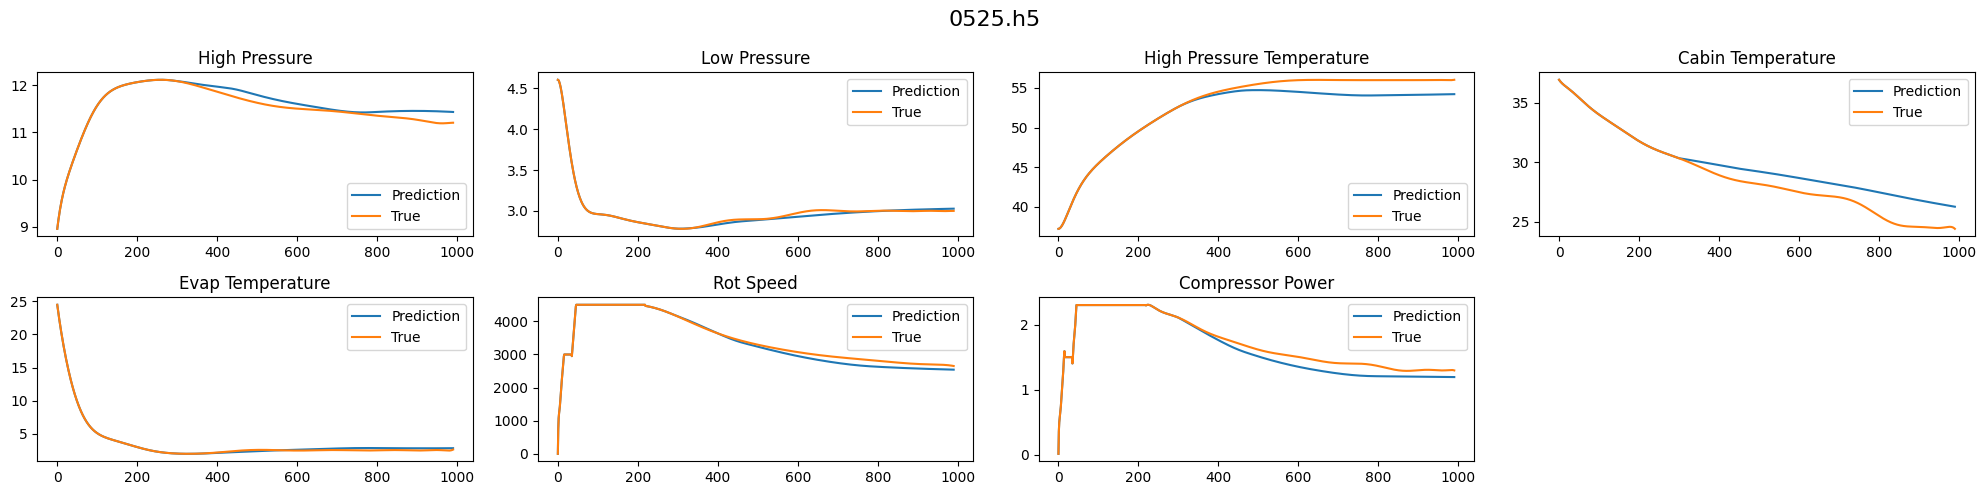

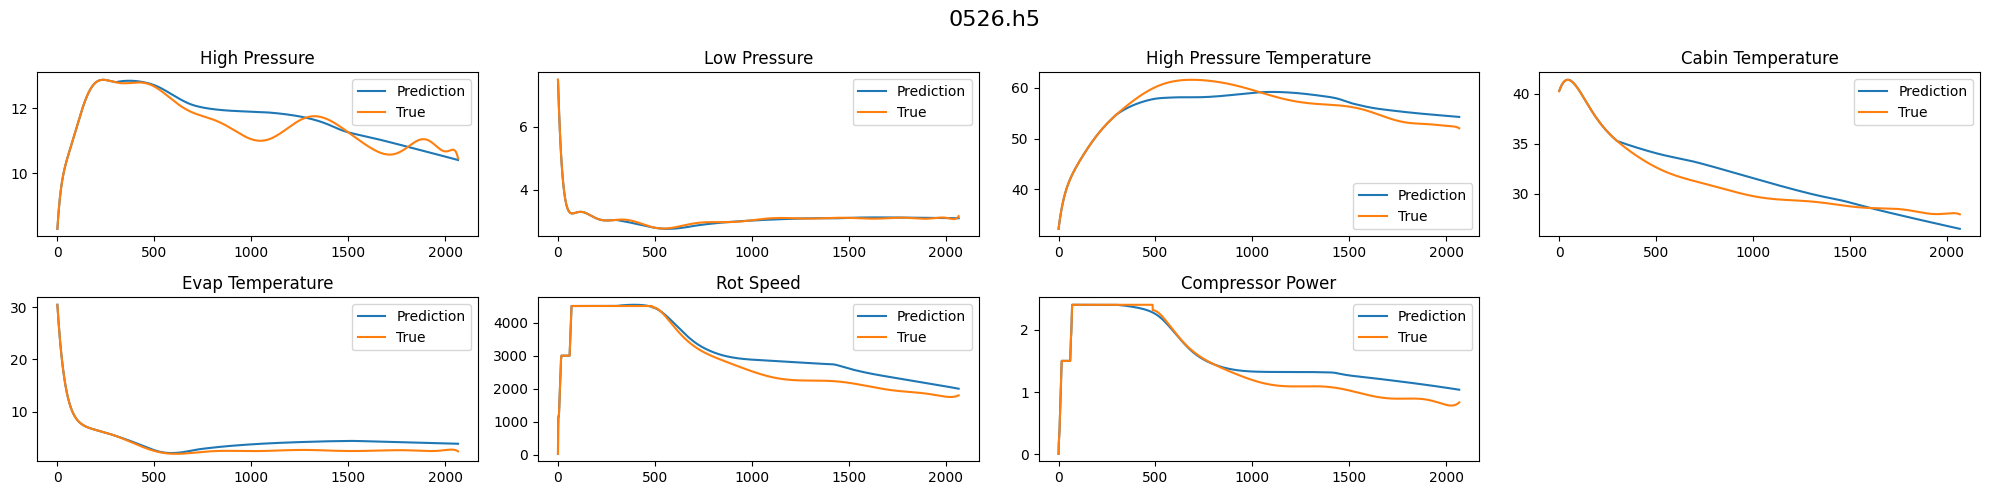

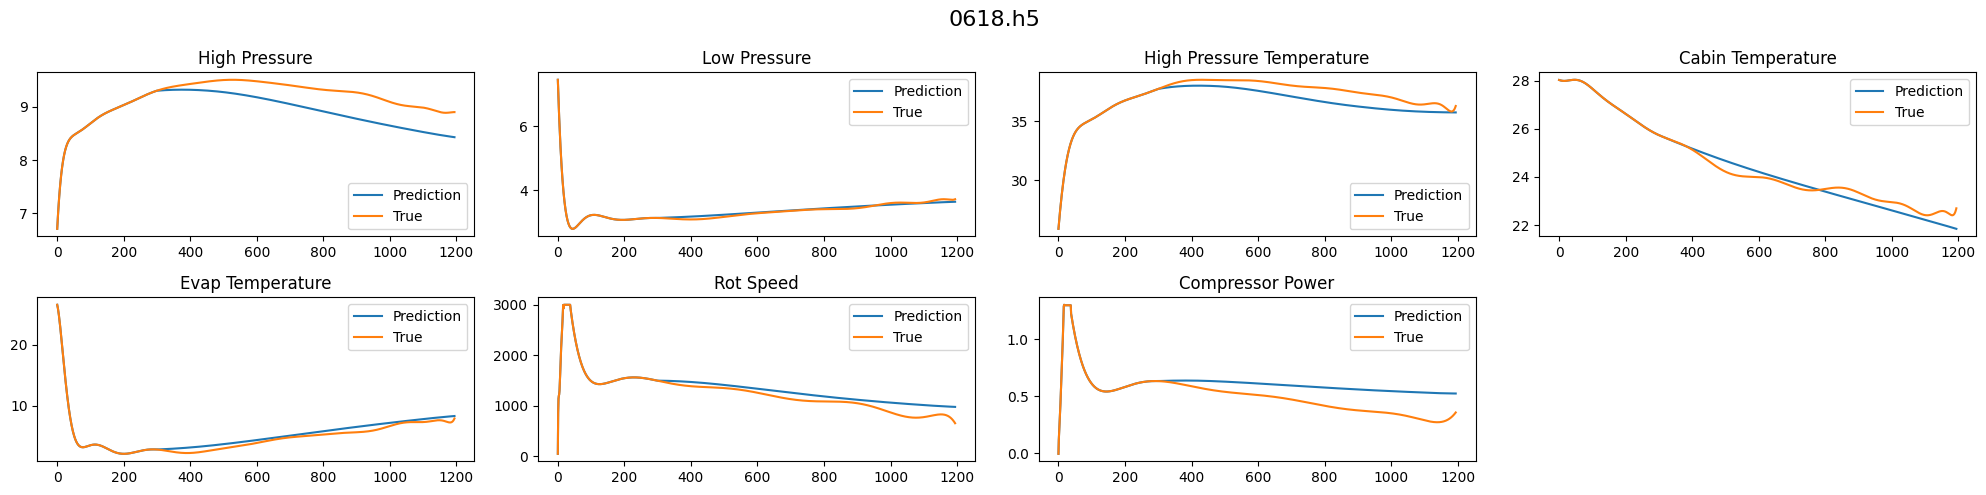

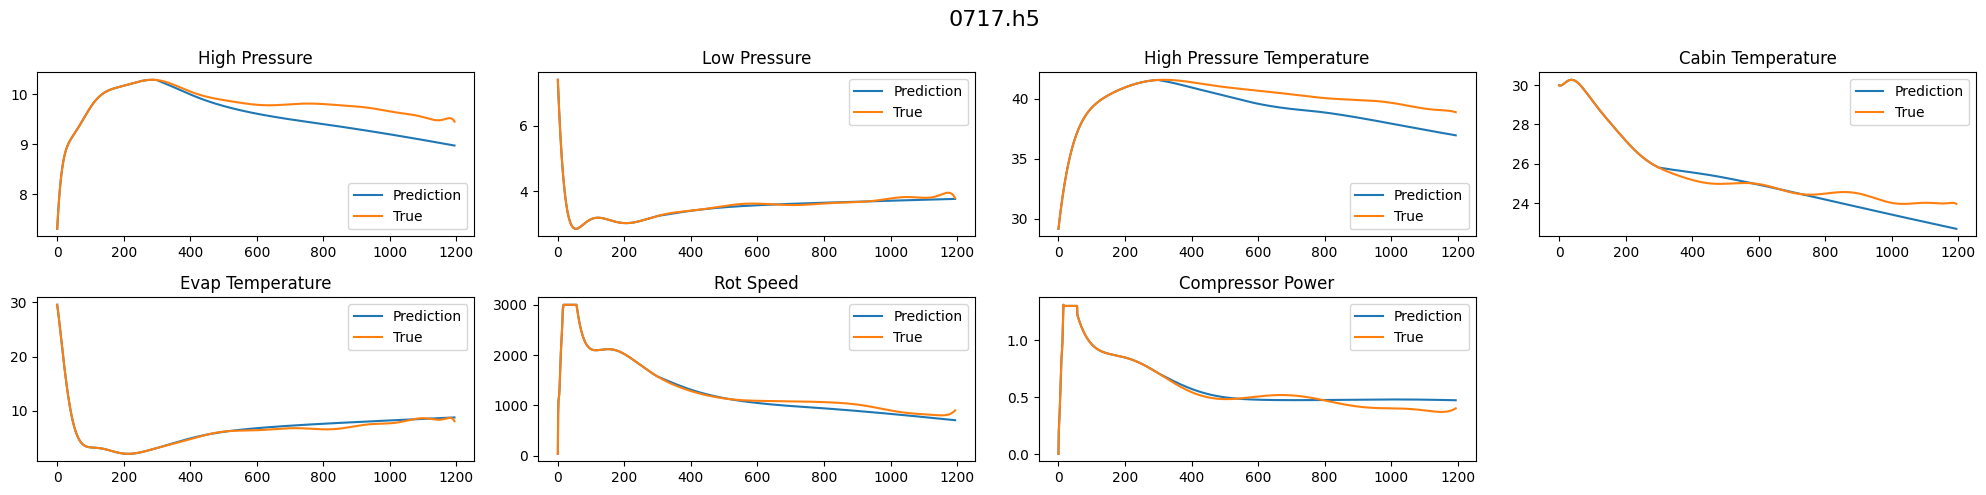

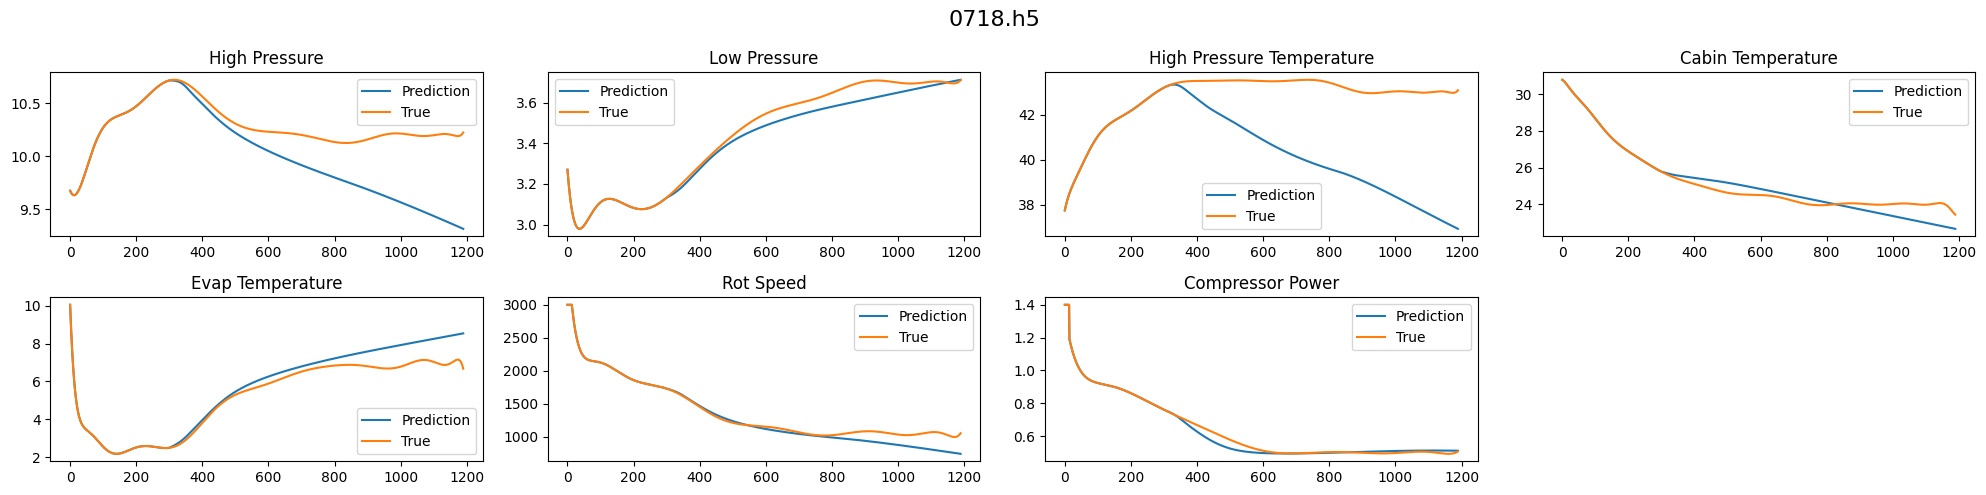

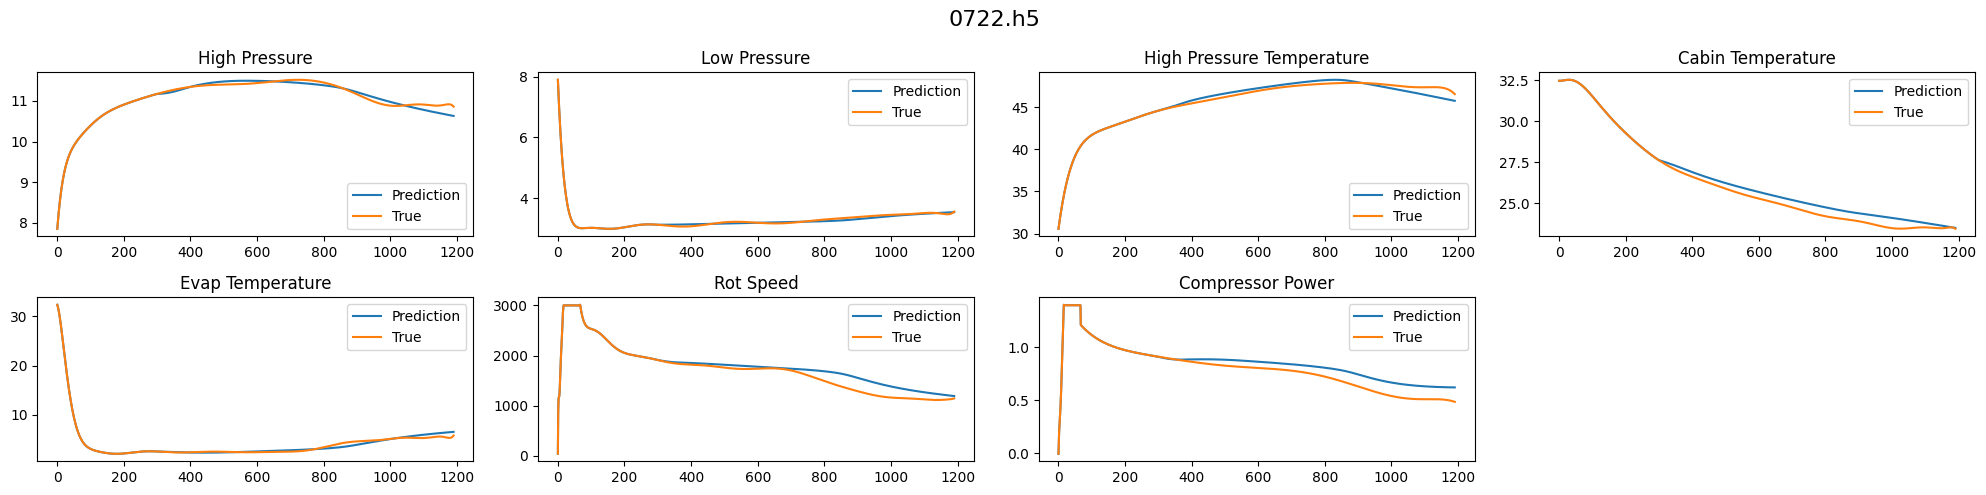

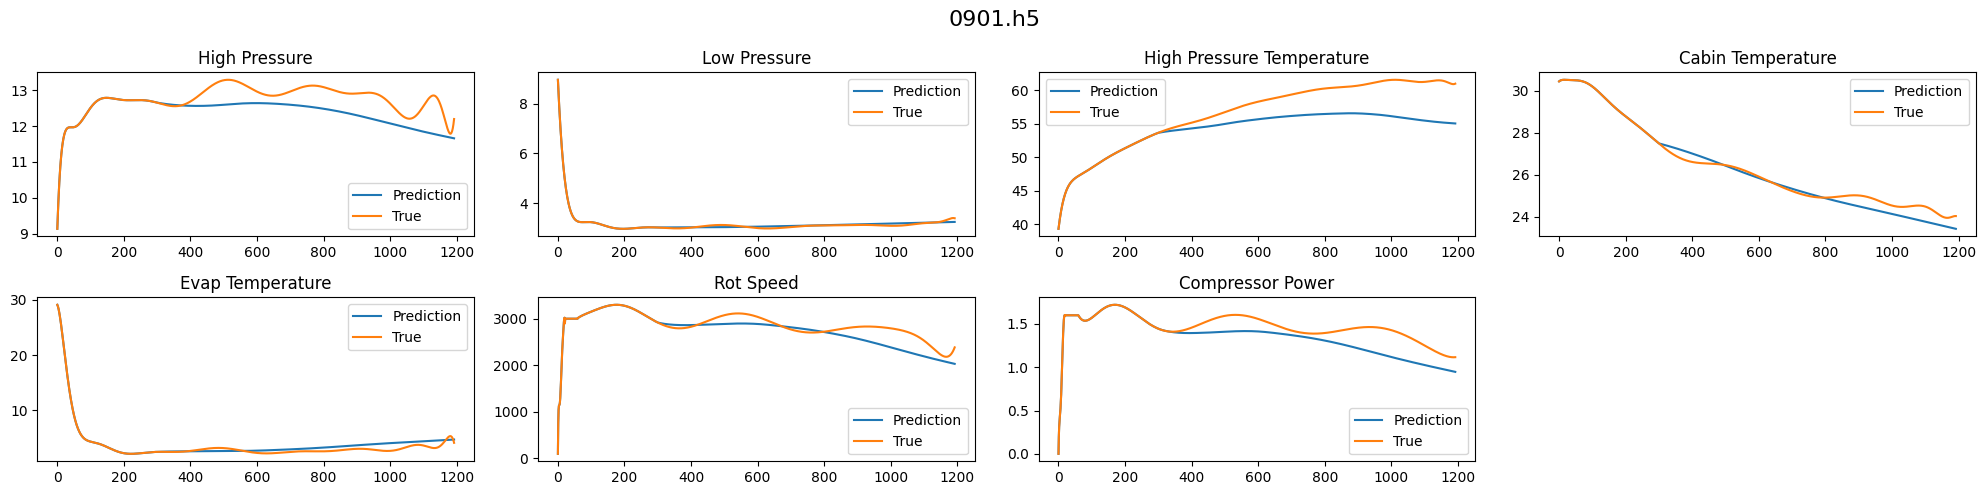

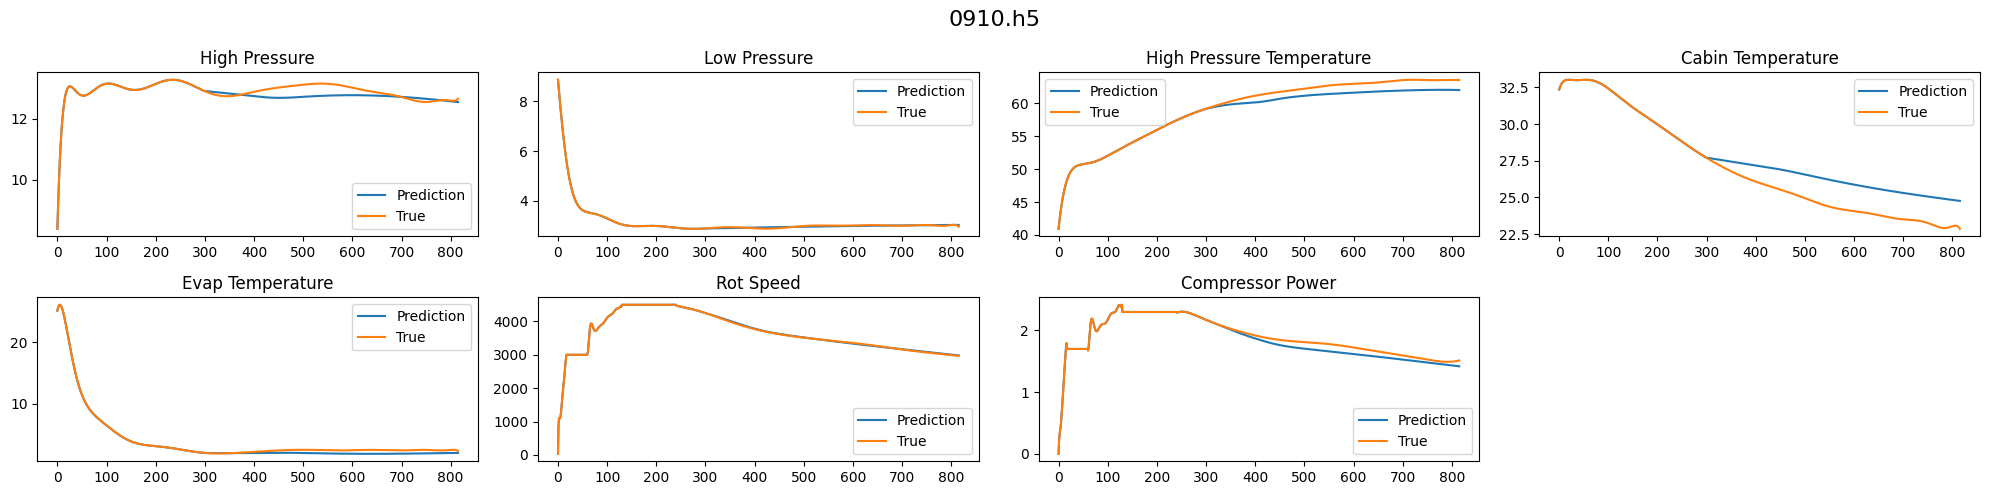

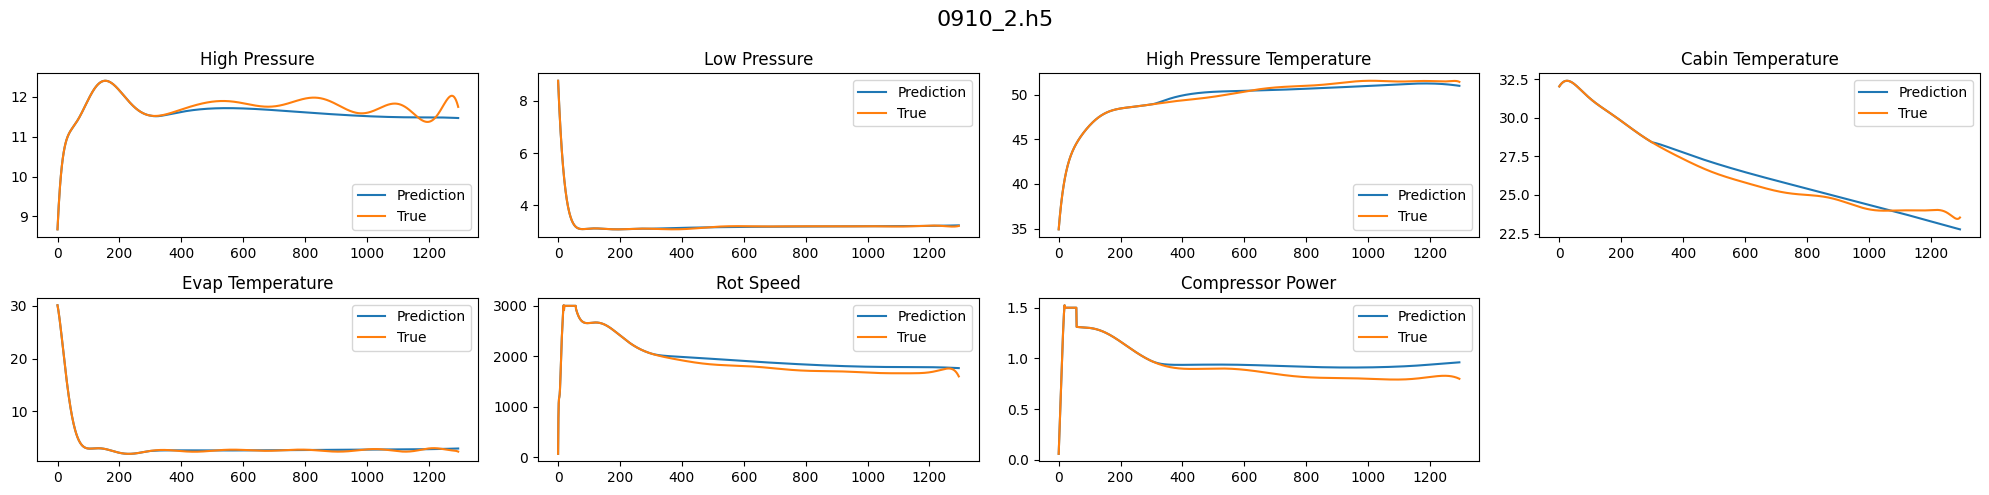

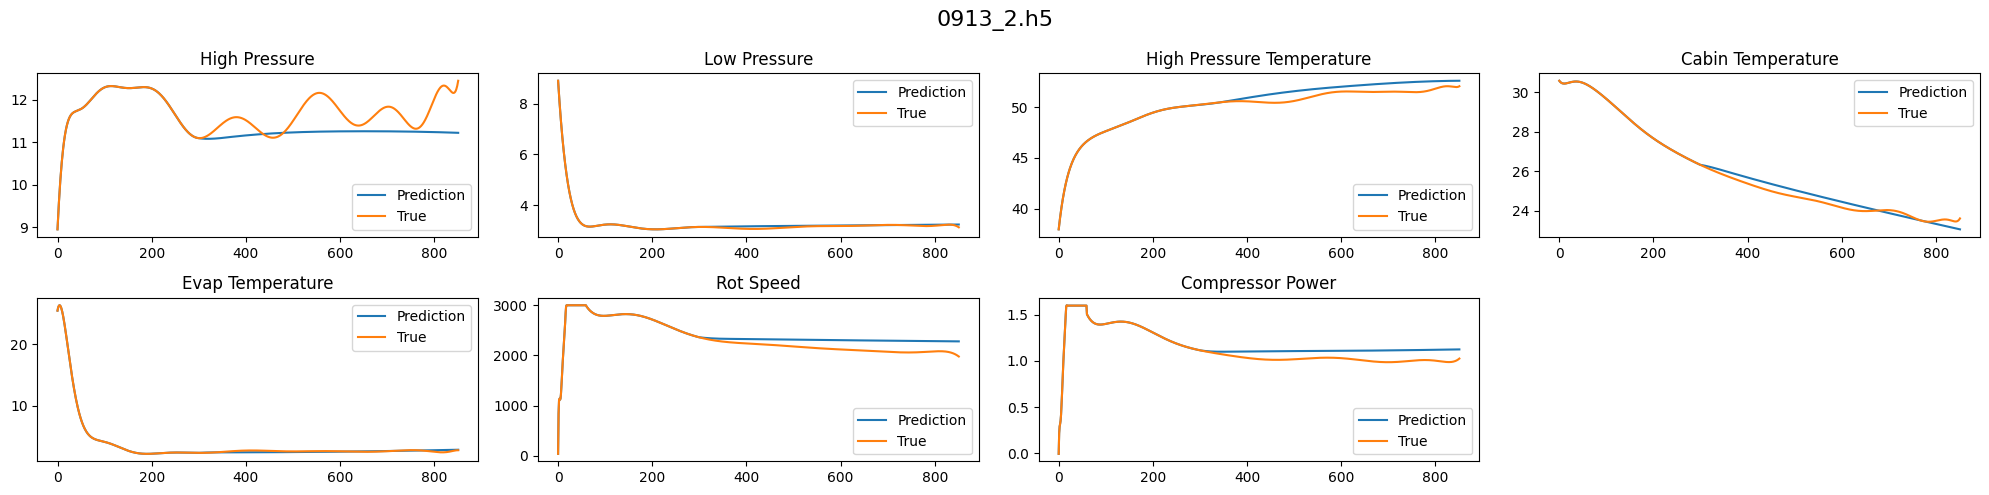

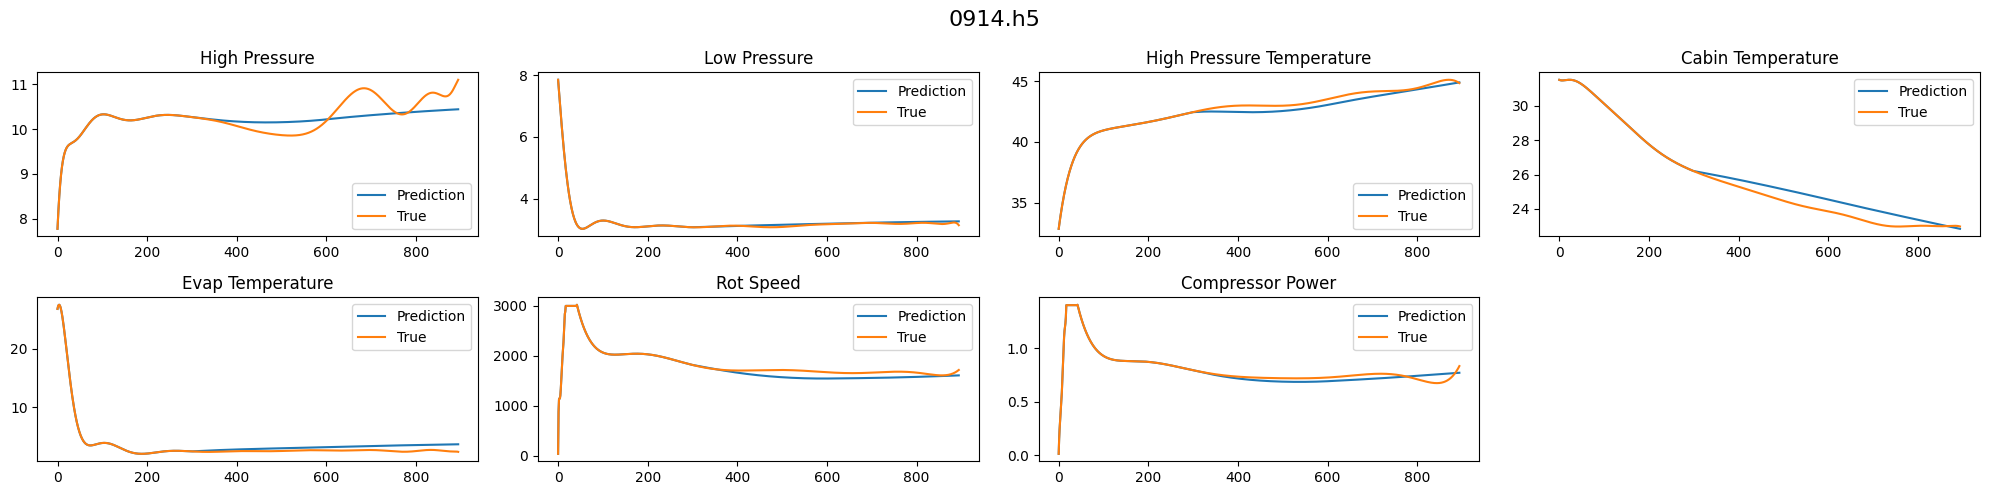

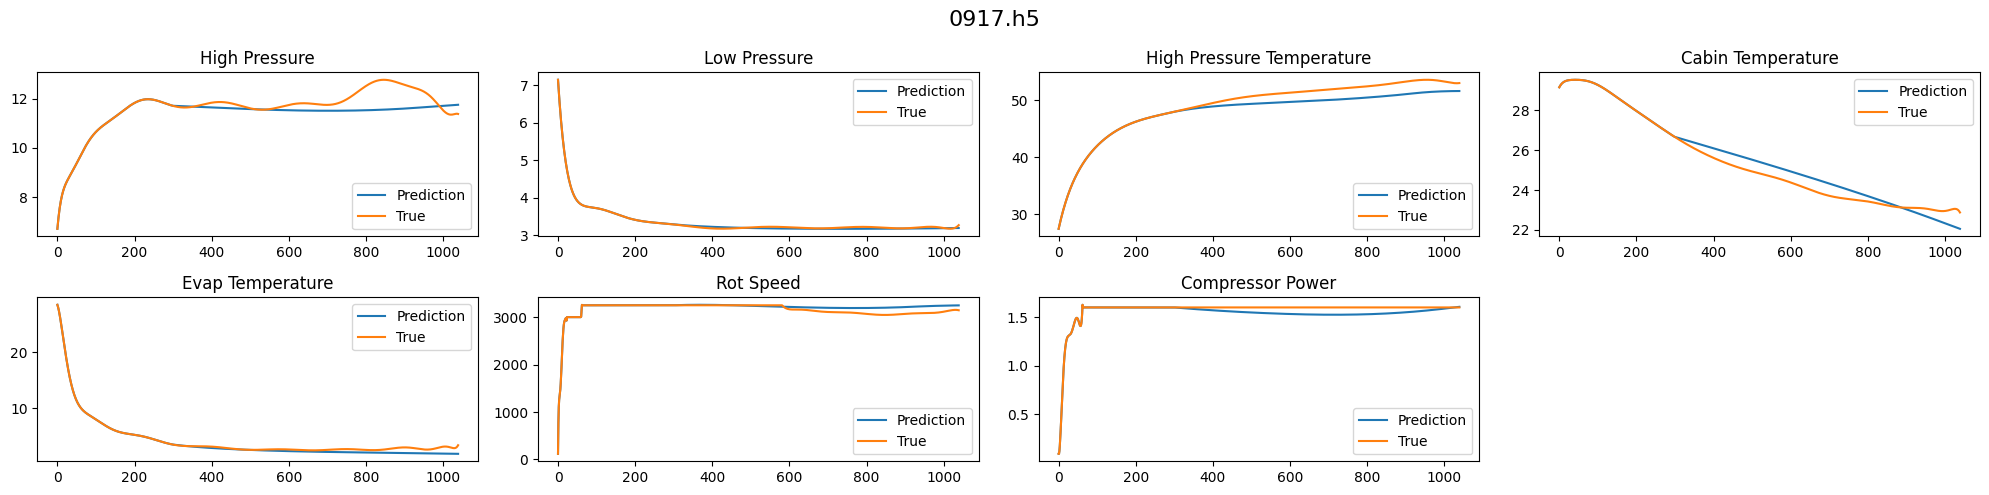

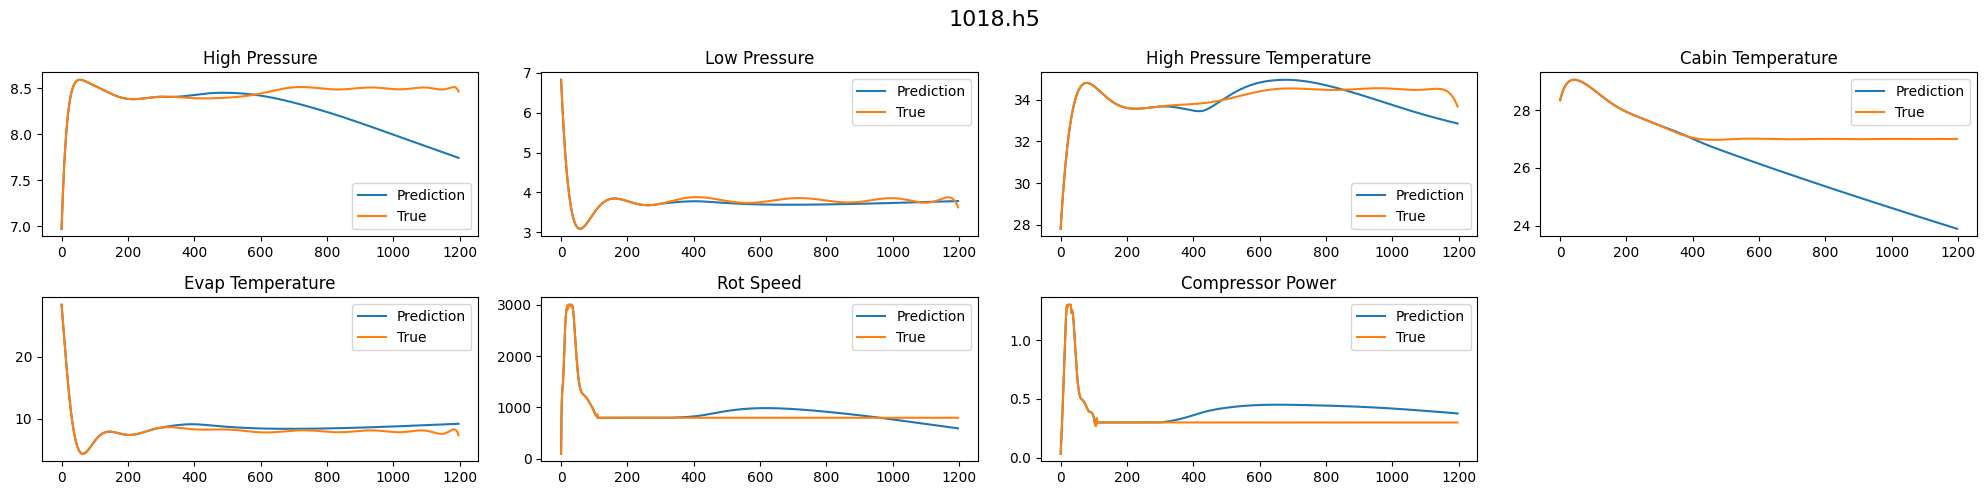

In [ ]:
import os
import h5py

with h5py.File("../cooling_data.h5","r") as hdf_file:
    means = hdf_file["means"][:]
    stds = hdf_file["stds"][:]

train_root = "../train_case"
train_trips = os.listdir(train_root)

for trip in train_trips:
    figure, axes = plt.subplots(nrows=2,ncols=4,figsize=(20,5))
    figure.suptitle(f"{trip}", fontsize=16)
    with h5py.File(f"{train_root}/{trip}","r") as hdf_file:
        data = hdf_file["data"][:]

    data_normalized = np.copy(data[:300,:])
    data_normalized[:,:itera_dim] = (data_normalized[:,:itera_dim]-means[:7])/stds[:7]

    data_tensor = torch.tensor(data_normalized)
    data_tensor = data_tensor.unsqueeze(0)
    data_tensor = data_tensor.to('cuda')

    input_len = 300
    data_len = data.shape[0]
    label_len = data_len

    xt_full = full_generate(test_model,data_tensor,label_len)
    xt_full = xt_full.squeeze(0)
    xt_full_numpy = xt_full.cpu().numpy()
    xt_full_numpy[:,:itera_dim] = xt_full_numpy[:,:itera_dim]*stds[:7]+means[:7]
        
    data_time = np.arange(data_len)

    for i in range(itera_dim):
        row = i//4
        col = i%4

        axes[row,col].plot(data_time,xt_full_numpy[:,i],label='Prediction')
        axes[row,col].plot(data_time,data[:,i],label='True')
        axes[row,col].legend()

    axes[0,0].set_title('High Pressure')
    axes[0,1].set_title('Low Pressure')
    axes[0,2].set_title('High Pressure Temperature')
    axes[0,3].set_title('Cabin Temperature')
    axes[1,0].set_title('Evap Temperature')
    axes[1,1].set_title('Rot Speed')
    axes[1,2].set_title('Compressor Power')
    axes[1,3].axis('off')

    plt.tight_layout()

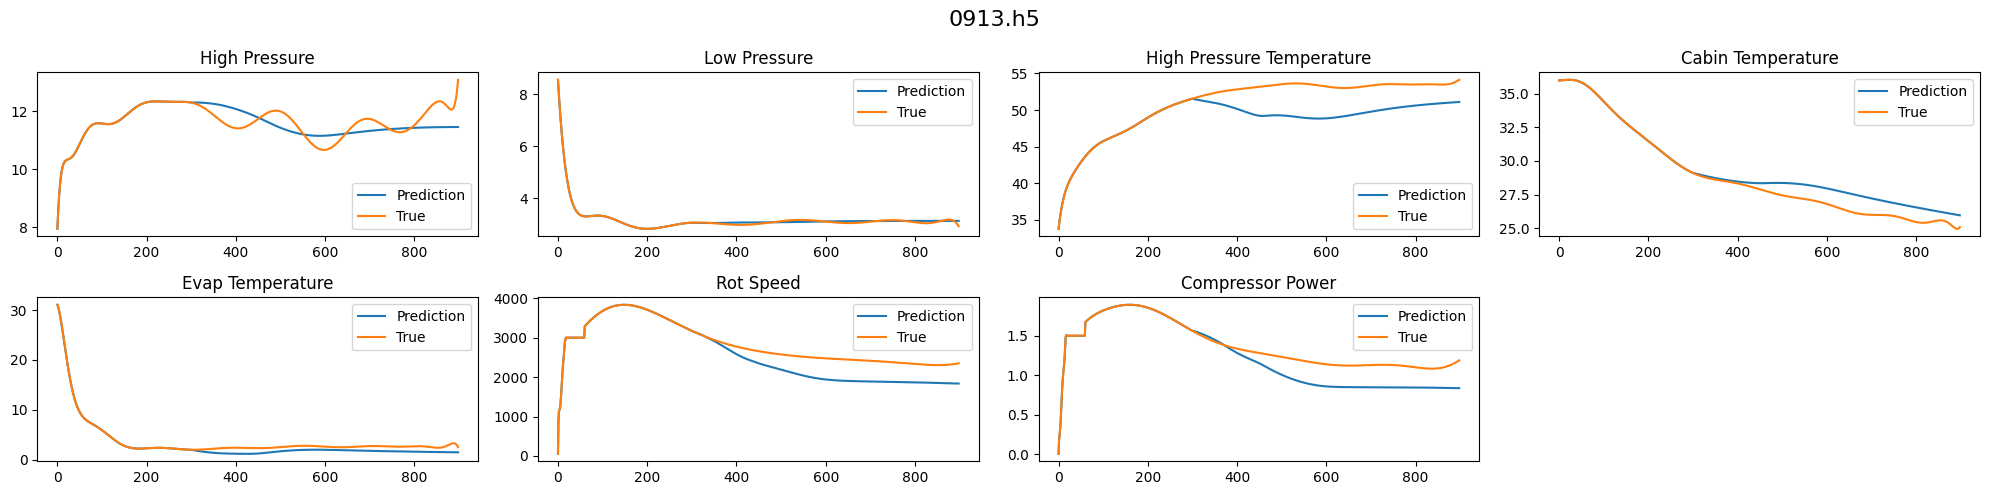

In [ ]:
import os
import h5py

with h5py.File("../cooling_data.h5","r") as hdf_file:
    means = hdf_file["means"][:]
    stds = hdf_file["stds"][:]

test_root = "../test_case"
test_trips = os.listdir(test_root)

for trip in test_trips:
    figure, axes = plt.subplots(nrows=2,ncols=4,figsize=(20,5))
    figure.suptitle(f"{trip}", fontsize=16)
    with h5py.File(f"{test_root}/{trip}","r") as hdf_file:
        data = hdf_file["data"][:]

    data_normalized = np.copy(data[:300,:])
    data_normalized[:,:itera_dim] = (data_normalized[:,:itera_dim]-means[:7])/stds[:7]

    data_tensor = torch.tensor(data_normalized)
    data_tensor = data_tensor.unsqueeze(0)
    data_tensor = data_tensor.to('cuda')

    input_len = 300
    data_len = data.shape[0]
    label_len = data_len

    xt_full = full_generate(test_model,data_tensor,label_len)
    xt_full = xt_full.squeeze(0)
    xt_full_numpy = xt_full.cpu().numpy()
    xt_full_numpy[:,:itera_dim] = xt_full_numpy[:,:itera_dim]*stds[:7]+means[:7]
        
    data_time = np.arange(data_len)

    for i in range(itera_dim):
        row = i//4
        col = i%4

        axes[row,col].plot(data_time,xt_full_numpy[:,i],label='Prediction')
        axes[row,col].plot(data_time,data[:,i],label='True')
        axes[row,col].legend()

    axes[0,0].set_title('High Pressure')
    axes[0,1].set_title('Low Pressure')
    axes[0,2].set_title('High Pressure Temperature')
    axes[0,3].set_title('Cabin Temperature')
    axes[1,0].set_title('Evap Temperature')
    axes[1,1].set_title('Rot Speed')
    axes[1,2].set_title('Compressor Power')
    axes[1,3].axis('off')

    plt.tight_layout()